# Predicting Apartment Rent Prices in Toronto
In this Python jupyter notebook we will go through an end-to-end machine learning project and build a predictive model for apartment rent prices in Toronto. This is a classic regression task, and we will go through the following:

1. Data collection.
2. Data preparation & feature engineering.
3. Model selection and evaluation.
4. Deployment.

In [1]:
# General libraries
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint

# Visualisations
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data preprocessing and transformers
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder

# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Evaluate regression models
from sklearn.metrics import mean_squared_error

# Save trained model
import joblib

## 1. Data collection
The data was scraped from the rental site https://www.rentals.ca/ and consists of ~6800 data points with 13 columns:

* price
* city
* street address
* postal code
* longitude
* latitude
* rental type
* number of bedrooms
* number of bathrooms
* sqft
* text description
* year built
* number of parking spots

The code can be found in the script folder. For now, we can look at the result below.

In [2]:
!head -10 "./data/toronto_apartment_rentals_2020.csv"

street_address,city,postal_code,price,longitude,latitude,rental_type,bedrooms,bathrooms,sqft,description_text,year_built,parking_spots
334 Gladstone Avenue,Toronto,M6J 3L6,2999.0,-79.43107110000001,43.65252319999999,Accommodation,,,,,,
38 Waterbury Drive,Etobicoke,M9R 3X6,1950.0,-79.57152339999999,43.6863867,Accommodation,2.0,1.0,,,,
11 Wellesley Street West,Toronto,M4Y 1E8,1950.0,-79.3852467,43.66450329999999,Accommodation,1.0,1.0,,,,
Candy Factory Loft - Penthouse,Toronto,M6J 1H2,8495.0,-79.4156165,43.6446488,Accommodation,,,,,,
77 Finch Avenue East,North York,M2N 6H8,1200.0,-79.41190979999999,43.7800854,Accommodation,,,,,,
832 Bay Street,Toronto,M5S 1Z6,2500.0,-79.3865112,43.661927,Accommodation,2.0,1.0,,,,
650 Lawrence,North York,M6A 3E8,2450.0,-79.4418464,43.7172871,Accommodation,3.0,1.0,,,,
25 Carlton Street,Toronto,M5B 1L4,2500.0,-79.3816605,43.6610457,Accommodation,2.0,1.0,,,,
8 Scollard Street,Toronto,M5R 1M2,2290.0,-79.38863640000001,43.6725941,Accommodation,2.0,1.0,,,,


In [3]:
# Count rows
!cat "./data/toronto_apartment_rentals_2020.csv" | wc -l

6832


## 2. Data preparation

### 2.1. Exploration & feature engineering

Let's take a first look at the data.

In [4]:
# Load and display dataset
df = pd.read_csv("./data/toronto_apartment_rentals_2020.csv")
df

,street_address,city,postal_code,price,longitude,latitude,rental_type,bedrooms,bathrooms,sqft,description_text,year_built,parking_spots
0,334 Gladstone Avenue,Toronto,M6J 3L6,2999.0,-79.431071,43.652523,Accommodation,NaN,NaN,NaN,NaN,NaN,NaN
1,38 Waterbury Drive,Etobicoke,M9R 3X6,1950.0,-79.571523,43.686387,Accommodation,2.0,1.0,NaN,NaN,NaN,NaN
2,11 Wellesley Street West,Toronto,M4Y 1E8,1950.0,-79.385247,43.664503,Accommodation,1.0,1.0,NaN,NaN,NaN,NaN
3,Candy Factory Loft - Penthouse,Toronto,M6J 1H2,8495.0,-79.415616,43.644649,Accommodation,NaN,NaN,NaN,NaN,NaN,NaN
4,77 Finch Avenue East,North York,M2N 6H8,1200.0,-79.411910,43.780085,Accommodation,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6826,38 Elm Street,Toronto,M5G 2K5,2400.0,-79.383640,43.657599,Accommodation,1.0,1.0,NaN,NaN,NaN,NaN
6827,500 Sherbourne Street,Toronto,M4X 1L1,2975.0,-79.375682,43.667902,Accommodation,2.0,2.0,900.0,"500 SHERBOURNE STREET, SUITE 803\n\nTORONTO - ...",NaN,NaN
6828,159 Gerrard Street East,Toronto,M5A 2E4,3195.0,-79.374276,43.660670,Apartment,3.0,1.0,NaN,NaN,NaN,NaN
6829,460 Adelaide Street East,Toronto,M5A 1N6,2150.0,-79.366487,43.652770,Accommodation,1.0,1.0,NaN,NaN,NaN,NaN


At first sight some columns have a lot of missing values.

In [5]:
df.isna().sum()

street_address         0
city                   0
postal_code           21
price                  0
longitude              0
latitude               0
rental_type            0
bedrooms             899
bathrooms           1013
sqft                5182
description_text    5192
year_built          6119
parking_spots       6119
dtype: int64

It looks like the last 4 columns are pretty sparse. Since there's so little in the last 3 columns and it's not clear how useful these features would be, for simplicity we will simply drop them. The sqft feature is also rather sparse, but it should have good predictive power and so we'll keep it. We can instead try to infer it from the other features.

We'll drop the street address column as well, since the location data is already encoded in the postal code and longitude/latitude.

Let's look at the rental type column.

In [6]:
df.rental_type.value_counts()

Accommodation    5919
Apartment         912
Name: rental_type, dtype: int64

Accommodation just seems like a generic term (as opposed to, say, apartment vs condo vs house). We'll drop this column as well since there isn't a clear divide between accommodation and apartment.

In [7]:
df = df.drop(['description_text', 'year_built', 'parking_spots', 'street_address', 'rental_type'], axis=1)

In [8]:
df

,city,postal_code,price,longitude,latitude,bedrooms,bathrooms,sqft
0,Toronto,M6J 3L6,2999.0,-79.431071,43.652523,NaN,NaN,NaN
1,Etobicoke,M9R 3X6,1950.0,-79.571523,43.686387,2.0,1.0,NaN
2,Toronto,M4Y 1E8,1950.0,-79.385247,43.664503,1.0,1.0,NaN
3,Toronto,M6J 1H2,8495.0,-79.415616,43.644649,NaN,NaN,NaN
4,North York,M2N 6H8,1200.0,-79.411910,43.780085,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
6826,Toronto,M5G 2K5,2400.0,-79.383640,43.657599,1.0,1.0,NaN
6827,Toronto,M4X 1L1,2975.0,-79.375682,43.667902,2.0,2.0,900.0
6828,Toronto,M5A 2E4,3195.0,-79.374276,43.660670,3.0,1.0,NaN
6829,Toronto,M5A 1N6,2150.0,-79.366487,43.652770,1.0,1.0,NaN


#### Infer missing values
A feature like the square footage should carry a lot of importance in determining price. Since we only have ~1700 rows with sqft data, we would like to infer it from the other (non-price) features. First let's take a look at the sqft data itself.

<AxesSubplot:>

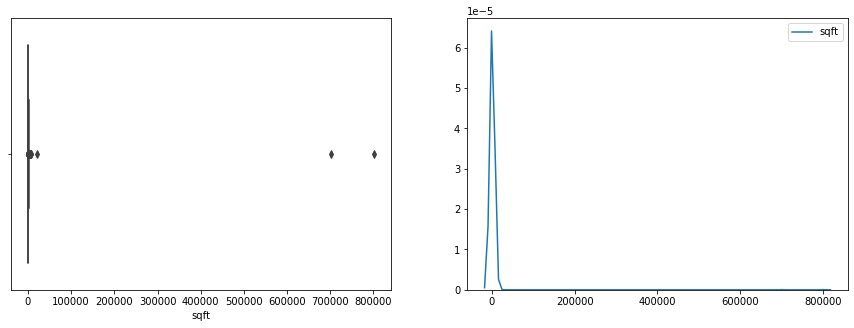

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(df.sqft, ax=axes[0])
sns.kdeplot(df.sqft, ax=axes[1])

In [10]:
df[df.sqft > 100000]

,city,postal_code,price,longitude,latitude,bedrooms,bathrooms,sqft
446,Vaughan,L4K 1W8,2350.0,-79.521298,43.795942,2.0,2.0,800899.0
6578,Toronto,M5J 0B1,3000.0,-79.382245,43.641850,2.0,2.0,700799.0


These seem to be clear errors. The owner probably meant to write a range like 800-899 sqft, so we'll pick the range middle point as value.

In [11]:
df.loc[446, 'sqft'] = 850
df.loc[6578, 'sqft'] = 750

<AxesSubplot:>

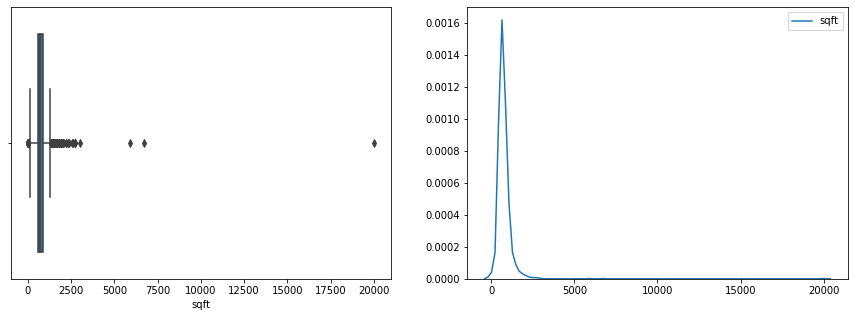

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(df.sqft, ax=axes[0])
sns.kdeplot(df.sqft, ax=axes[1])

In [13]:
df[df.sqft > 5000]

,city,postal_code,price,longitude,latitude,bedrooms,bathrooms,sqft
990,Toronto,M6B 2Z1,9900.0,-79.426037,43.705619,4.0,4.0,5900.0
5451,North York,M2M 2E4,3800.0,-79.414209,43.787862,5.0,2.0,20000.0
5829,Toronto,M5R 2T8,2000.0,-79.406443,43.672597,2.0,1.0,6700.0


These datapoints seem more genuine (that's one big house, but it's also in North York).

We can infer the missing values from the other features using [iterative imputing](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html). In short, for each feature with missing data, one can train a regression model on the other features and fill the missing values with the predicted ones.

In [14]:
# Infer missing values
impute_columns = df[['bedrooms', 'bathrooms', 'sqft', 'latitude', 'longitude']]
other_columns = df.drop(['bedrooms', 'bathrooms', 'sqft', 'latitude', 'longitude'], axis=1)

In [15]:
impute_columns

,bedrooms,bathrooms,sqft,latitude,longitude
0,NaN,NaN,NaN,43.652523,-79.431071
1,2.0,1.0,NaN,43.686387,-79.571523
2,1.0,1.0,NaN,43.664503,-79.385247
3,NaN,NaN,NaN,43.644649,-79.415616
4,NaN,NaN,NaN,43.780085,-79.411910
...,...,...,...,...,...
6826,1.0,1.0,NaN,43.657599,-79.383640
6827,2.0,2.0,900.0,43.667902,-79.375682
6828,3.0,1.0,NaN,43.660670,-79.374276
6829,1.0,1.0,NaN,43.652770,-79.366487


In [16]:
# Instantiate imputer
imp = IterativeImputer(max_iter=10, random_state=42, initial_strategy='median')

# Fit imputer on data
imp.fit(impute_columns)

# Transform impute_columns
filled_columns = pd.DataFrame(imp.transform(impute_columns), columns=impute_columns.columns)

In [17]:
filled_columns

,bedrooms,bathrooms,sqft,latitude,longitude
0,1.643610,1.333009,809.493593,43.652523,-79.431071
1,2.000000,1.000000,946.382590,43.686387,-79.571523
2,1.000000,1.000000,548.168647,43.664503,-79.385247
3,1.617246,1.311559,791.577622,43.644649,-79.415616
4,1.927558,1.525194,972.947696,43.780085,-79.411910
...,...,...,...,...,...
6826,1.000000,1.000000,545.054086,43.657599,-79.383640
6827,2.000000,2.000000,900.000000,43.667902,-79.375682
6828,3.000000,1.000000,1237.402968,43.660670,-79.374276
6829,1.000000,1.000000,539.186295,43.652770,-79.366487


We should have filled most of our missing data. Let's compare missing values pre and post imputing.

In [18]:
# Missing values pre-imputing
df.isna().sum()

city              0
postal_code      21
price             0
longitude         0
latitude          0
bedrooms        899
bathrooms      1013
sqft           5182
dtype: int64

In [19]:
# Merge filled_columns and other_columns back
df = pd.merge(filled_columns, other_columns, left_index=True, right_index=True)

In [20]:
# Missing values post-imputing
df.isna().sum()

bedrooms        0
bathrooms       0
sqft            0
latitude        0
longitude       0
city            0
postal_code    21
price           0
dtype: int64

In [21]:
df.shape

(6831, 8)

#### The city and postal code columns
Finally we look at these two categorical columns

In [22]:
df.city.value_counts()

Toronto        4616
North York      970
Scarborough     411
Etobicoke       386
York            161
Vaughan         107
East York        99
Mississauga      49
Markham          30
Brampton          2
Name: city, dtype: int64

In [23]:
df.postal_code.value_counts()

None       57
M5B 2C2    52
M5A 1Z4    42
L4K 2M7    36
M5A 2Y8    33
           ..
M1K 1V8     1
M5V 1K5     1
M4V 2H3     1
M6J 3C3     1
M6K 3A2     1
Name: postal_code, Length: 2614, dtype: int64

The postal code column has missing data entered as 'None' on top of the 21 NaN listed above. We can convert them to NaN, and at this point, we will drop all remaining rows with missing data.

In [24]:
# Drop remaining rows with missing values
df = df.replace('None', np.NaN)
df = df.dropna()

In [25]:
df.shape

(6753, 8)

Finally, the 6 digit postal code seems like it's a bit too granular as we have 2614 distinct entries. We'll extract the first 3 digits of each code to group properties within similar areas.

In [26]:
# Extract first 3 digits of postal_code
df.postal_code = df.postal_code.apply(lambda x: x[:3])

In [27]:
df.postal_code.value_counts()

M5V    1001
M4Y     456
M5A     367
M5J     302
M2N     299
       ... 
M5Y       1
m4v       1
M3E       1
l4X       1
m4g       1
Name: postal_code, Length: 115, dtype: int64

In [28]:
df

,bedrooms,bathrooms,sqft,latitude,longitude,city,postal_code,price
0,1.643610,1.333009,809.493593,43.652523,-79.431071,Toronto,M6J,2999.0
1,2.000000,1.000000,946.382590,43.686387,-79.571523,Etobicoke,M9R,1950.0
2,1.000000,1.000000,548.168647,43.664503,-79.385247,Toronto,M4Y,1950.0
3,1.617246,1.311559,791.577622,43.644649,-79.415616,Toronto,M6J,8495.0
4,1.927558,1.525194,972.947696,43.780085,-79.411910,North York,M2N,1200.0
...,...,...,...,...,...,...,...,...
6826,1.000000,1.000000,545.054086,43.657599,-79.383640,Toronto,M5G,2400.0
6827,2.000000,2.000000,900.000000,43.667902,-79.375682,Toronto,M4X,2975.0
6828,3.000000,1.000000,1237.402968,43.660670,-79.374276,Toronto,M5A,3195.0
6829,1.000000,1.000000,539.186295,43.652770,-79.366487,Toronto,M5A,2150.0


### 2.2. Visualisations

#### Price distribution

<AxesSubplot:>

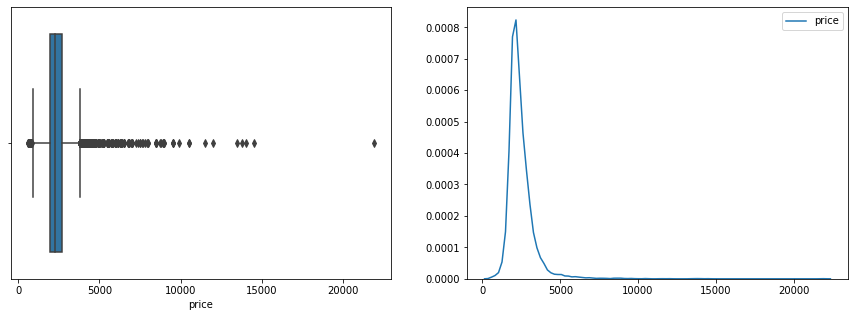

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(df.price, ax=axes[0])
sns.kdeplot(df.price, ax=axes[1])

There are some clear price outliers. Let's fix this by dropping the first and last 5% quantiles of price data.

In [30]:
# drop the first and last 5% quantiles
df = df[df.price.between(df.price.quantile(0.05), df.price.quantile(0.95))]

<AxesSubplot:>

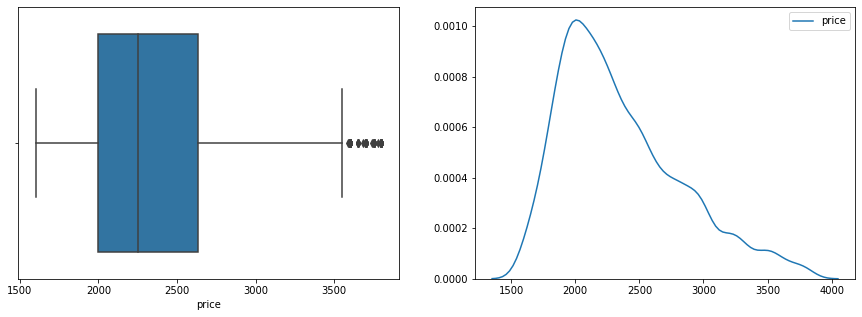

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(df.price, ax=axes[0])
sns.kdeplot(df.price, ax=axes[1])

In [32]:
df[df.price >= 3500]

,bedrooms,bathrooms,sqft,latitude,longitude,city,postal_code,price
15,3.000000,2.000000,1332.060845,43.640527,-79.397104,Toronto,M5V,3800.0
19,3.000000,2.000000,1331.951335,43.685292,-79.319300,Toronto,M4C,3750.0
43,3.000000,4.000000,1584.904699,43.781543,-79.405602,North York,M2N,3600.0
79,2.000000,2.000000,995.672755,43.671801,-79.387633,Toronto,M4W,3800.0
117,2.000000,2.000000,989.526746,43.655180,-79.389638,Toronto,M5T,3500.0
...,...,...,...,...,...,...,...,...
6645,1.593235,1.291247,774.670649,43.638332,-79.397831,Toronto,M5V,3500.0
6663,1.706047,1.370630,841.911221,43.685679,-79.404689,Toronto,M4V,3500.0
6781,3.000000,2.000000,1336.474829,43.658836,-79.384655,Toronto,M5G,3500.0
6786,2.000000,2.000000,993.051122,43.665517,-79.387096,Toronto,M5S,3500.0


In [33]:
df[df.price <= 1700]

,bedrooms,bathrooms,sqft,latitude,longitude,city,postal_code,price
189,1.00000,1.000000,800.000000,43.663109,-79.375154,Toronto,M5A,1659.0
196,2.00000,1.000000,800.000000,43.718479,-79.260475,Scarborough,M1K,1600.0
208,1.00000,1.000000,594.808222,43.764094,-79.415858,North York,M2N,1650.0
215,1.00000,1.000000,560.000000,43.614332,-79.487306,Etobicoke,M8V,1700.0
218,1.63832,1.317654,797.502978,43.663109,-79.375154,Toronto,M5A,1659.0
...,...,...,...,...,...,...,...,...
6480,1.00000,1.000000,550.000000,43.669195,-79.452815,Toronto,M6N,1600.0
6484,1.00000,1.000000,600.000000,43.609696,-79.592960,Mississauga,L4Y,1699.0
6521,2.00000,1.000000,920.770784,43.794746,-79.273062,Scarborough,M1S,1650.0
6561,1.00000,1.000000,589.380038,43.786449,-79.353657,North York,M2J,1600.0


In [34]:
np.mean(df.price)

2353.290710915894

In [35]:
np.std(df.price)

474.7314238176986

In [36]:
df.shape

(6147, 8)

#### Location distribution
Since we have the Latitude/Longitude data, we can see where our datapoints are situated. We can use [geopandas](https://geopandas.org/) to overlay a scatterplot onto a plot of Toronto, or of the Greater Toronto Area.

In [37]:
toronto_map = gpd.read_file("./data/shapefiles/toronto/CENTRELINE_WGS84.shp")
gta_map = gpd.read_file("./data/shapefiles/gta/GTA2013_Index.shp")

Let's look at where our data is situated within the GTA.

Text(109.3490879304675, 0.5, 'Latitude')

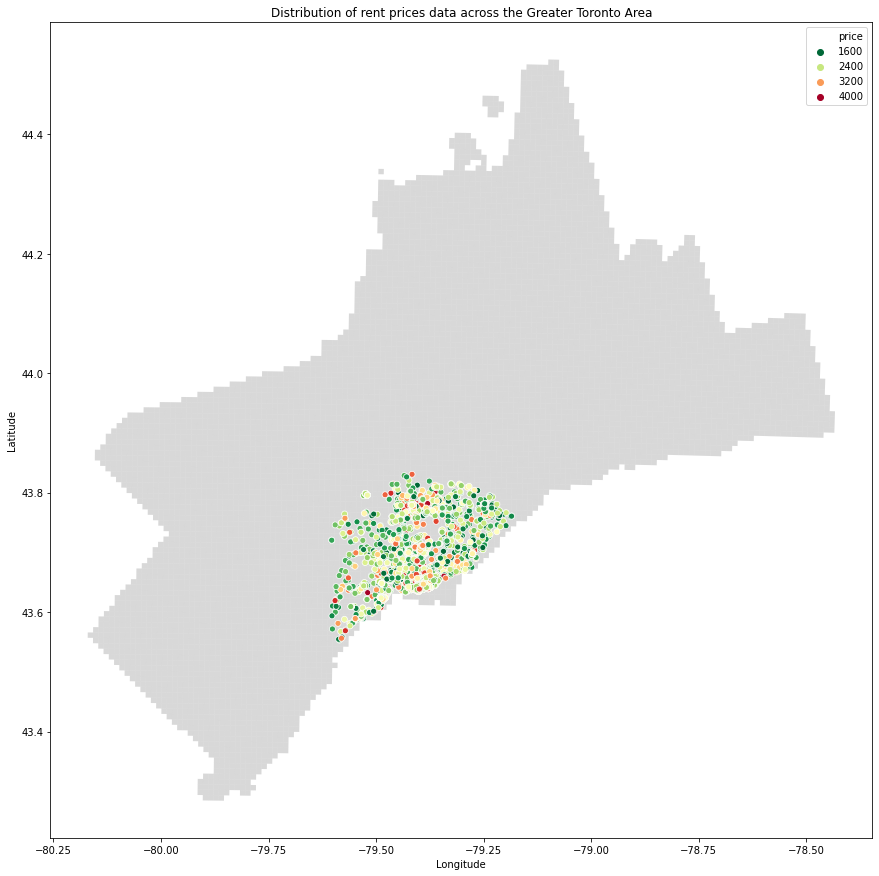

In [38]:
fig, ax = plt.subplots(figsize=(15, 15))

gta_map.plot(ax=ax, alpha=0.3, color='grey')
sns.scatterplot(df.longitude, df.latitude, ax=ax, hue=df.price, palette='RdYlGn_r')
ax.set_title('Distribution of rent prices data across the Greater Toronto Area')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

Now let's look at Toronto proper.

Text(95.5, 0.5, 'Latitude')

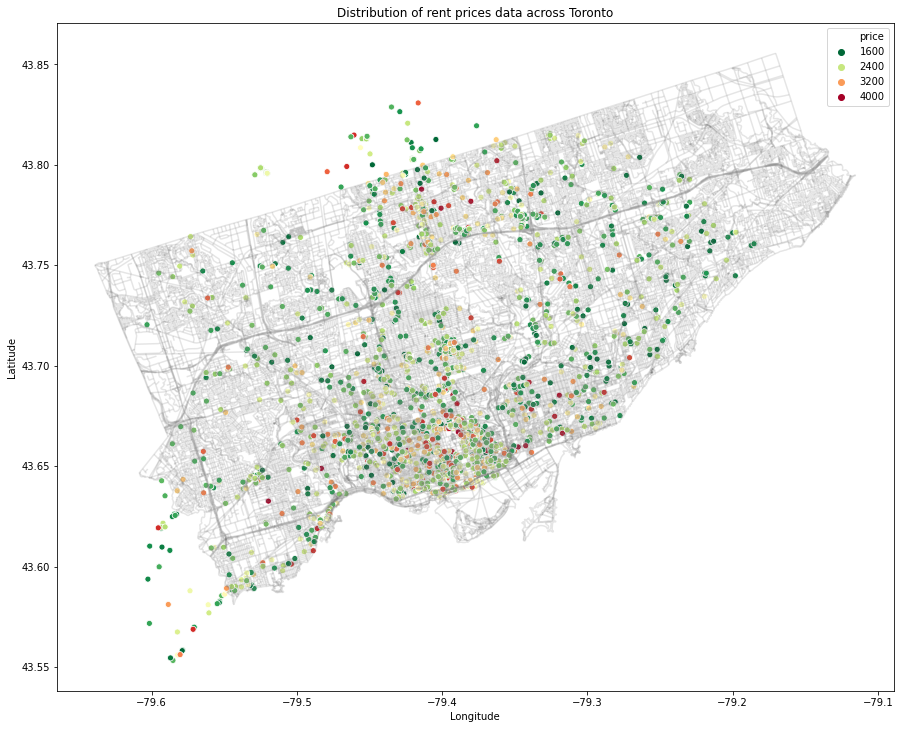

In [39]:
fig, ax = plt.subplots(figsize=(15, 15))

toronto_map.plot(ax=ax, alpha=0.2, color='grey')
sns.scatterplot(df.longitude, df.latitude, ax=ax, hue=df.price, palette='RdYlGn_r')
ax.set_title('Distribution of rent prices data across Toronto')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

There are some clear concentrations of high rent places around downtown Toronto and the North York area, while rent seems to get cheaper as you go further west/east of Toronto.

Next, let's look at the distribution of postal codes.

Text(0.5, 0, 'Postal code frequency')

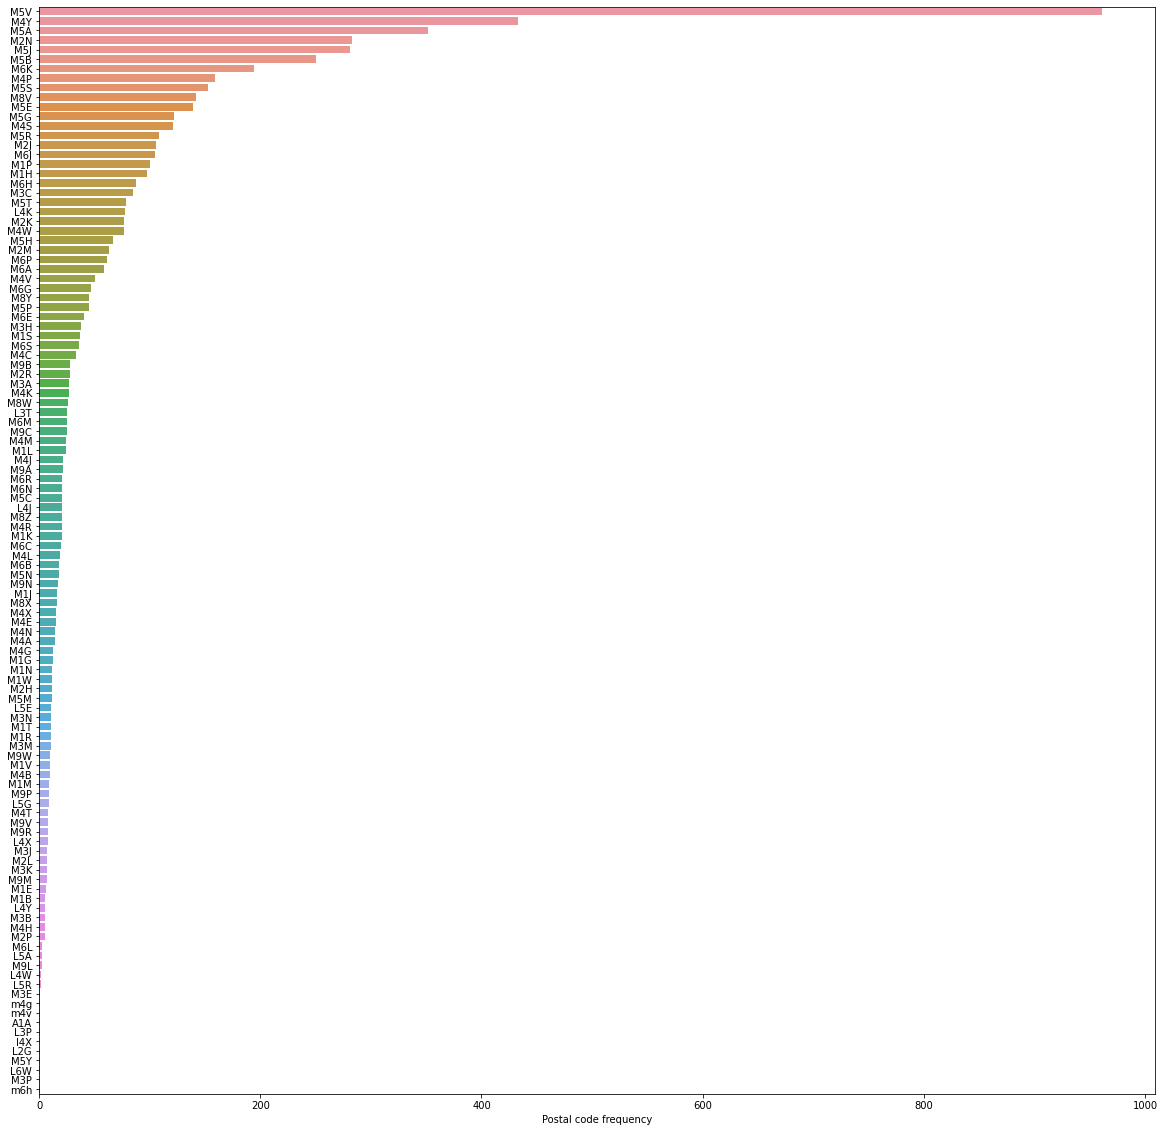

In [40]:
postal_codes = df.postal_code.value_counts()

fig, ax = plt.subplots(figsize=(20, 20))
sns.barplot(x=postal_codes, y=postal_codes.index)
ax.set_xlabel('Postal code frequency')

Looking up these postal codes, we again see that the data seems heavily concentrated downtown and in North York. Let's look at the  6 most frequent postal codes:

* [M5V](https://www.google.com/maps/place/Toronto,+ON+M5V/@43.6314062,-79.4116401,14z/data=!3m1!4b1!4m5!3m4!1s0x882b35252b71ef0d:0xee11d2dff47e9a1!8m2!3d43.6289467!4d-79.3944199) : Fashion/Entertainment District & Toronto Islands
* [M4Y](https://www.google.com/maps/place/Toronto,+ON+M4Y/@43.6666517,-79.3903063,15z/data=!3m1!4b1!4m5!3m4!1s0x882b34b2c1714f89:0xd093238d56b31c9c!8m2!3d43.6658599!4d-79.3831599) : Church & Wellesley Area
* [M5A](https://www.google.com/maps/place/Toronto,+ON+M5A/@43.6499487,-79.3878643,13z/data=!3m1!4b1!4m5!3m4!1s0x89d4cb16c81cbaa7:0x33cea1547f0c5278!8m2!3d43.6542599!4d-79.3606359) : Corktown & Cabbagetown South Area
* [M2N](https://www.google.com/maps/place/North+York,+ON+M2N/@43.7681432,-79.448698,13z/data=!3m1!4b1!4m5!3m4!1s0x882b2d6fd314b9eb:0x2f13d8da0be397e4!8m2!3d43.7701199!4d-79.4084928) : North York - Willowdale Area
* [M5J](https://www.google.com/maps/place/Toronto,+ON+M5J/@43.6297434,-79.4014638,13z/data=!4m5!3m4!1s0x89d4cada7048225d:0x8ff689c9a9de81d0!8m2!3d43.6408157!4d-79.3817523) : Waterfront & Toronto Islands
* [M5B](https://www.google.com/maps/place/Toronto,+ON+M5B/@43.6530176,-79.3988573,14.1z/data=!4m5!3m4!1s0x89d4cb356600009f:0x5815e4db84791f34!8m2!3d43.6571618!4d-79.3789371) : Ryerson University Area




Next, let's look at the longtitude/latitude distributions.

<AxesSubplot:>

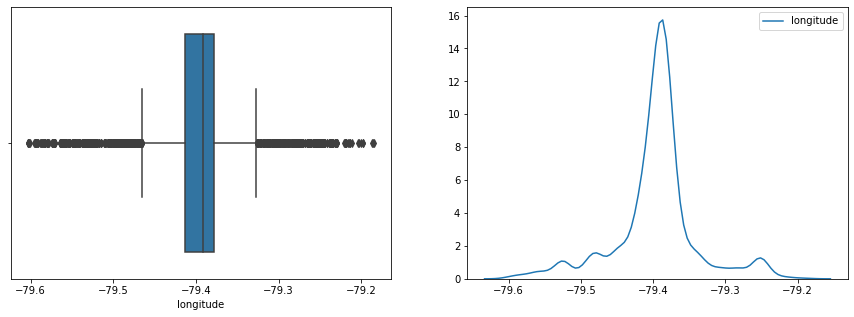

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(df.longitude, ax=axes[0])
sns.kdeplot(df.longitude, ax=axes[1])

<AxesSubplot:>

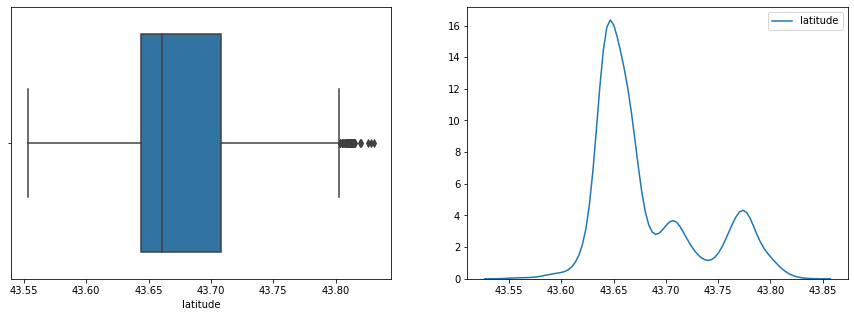

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(df.latitude, ax=axes[0])
sns.kdeplot(df.latitude, ax=axes[1])

It's clear our data is concentrated in a vertical corridor centered on downtown. We also see small bumps in the Yonge/Eglinton and North York areas on the latitude plots.

#### Features scatter matrix

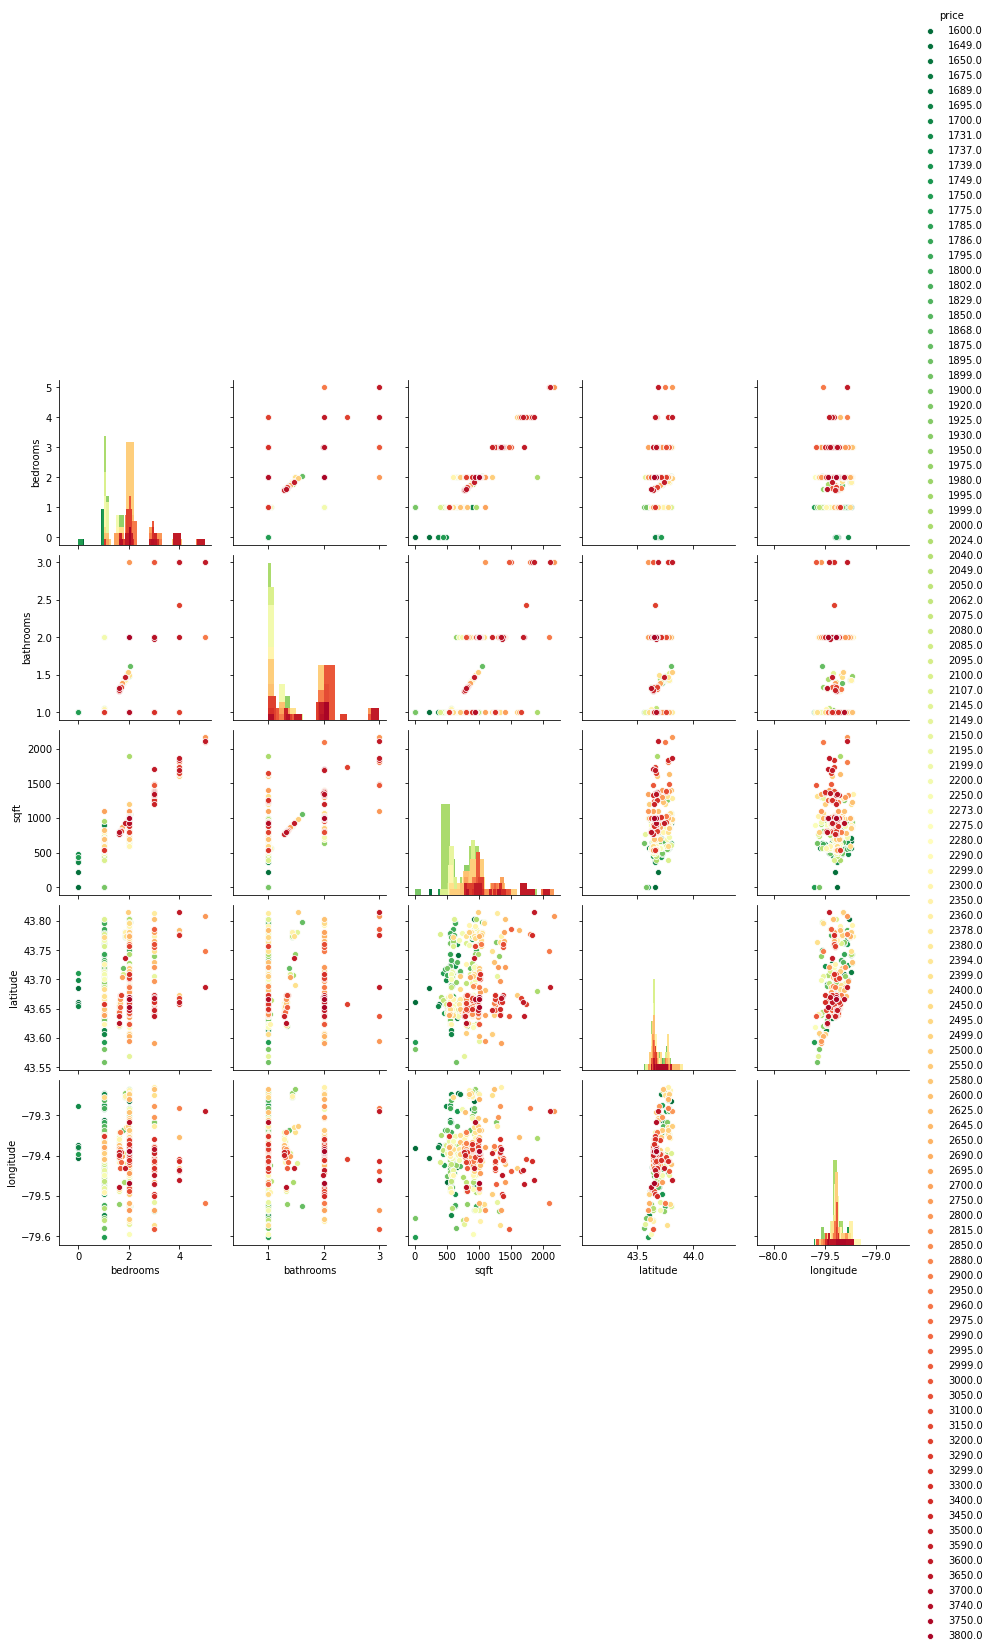

In [43]:
sns.pairplot(df.sample(500), hue='price', diag_kind='hist', palette='RdYlGn_r')

### 2.3. OneHotEncode
Finally we encode categorical features (city, postal code) as 0/1 variables.

In [44]:
# Split categorical from numerical data
df_categorical = df.select_dtypes(include=[object])
df_numerical = df.drop(columns=df_categorical.columns, axis=1)
    
# Fit one-hot encoder on categorical data
onehot = OneHotEncoder(handle_unknown='ignore')
onehot.fit(df_categorical)

# Transform categorical data
df_onehot = pd.DataFrame(onehot.transform(df_categorical).toarray(), 
                         columns=onehot.get_feature_names(),
                         index=df_categorical.index)

# Merge data
df = pd.merge(df_numerical, df_onehot, left_index=True, right_index=True)

# Display
df

,bedrooms,bathrooms,sqft,latitude,longitude,price,x0_Brampton,x0_East York,x0_Etobicoke,x0_Markham,...,x1_M9M,x1_M9N,x1_M9P,x1_M9R,x1_M9V,x1_M9W,x1_l4X,x1_m4g,x1_m4v,x1_m6h
0,1.64361,1.333009,809.493593,43.652523,-79.431071,2999.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.00000,1.000000,946.382590,43.686387,-79.571523,1950.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.00000,1.000000,548.168647,43.664503,-79.385247,1950.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.00000,1.000000,894.076951,43.661927,-79.386511,2500.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.00000,1.000000,1275.463512,43.717287,-79.441846,2450.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6826,1.00000,1.000000,545.054086,43.657599,-79.383640,2400.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6827,2.00000,2.000000,900.000000,43.667902,-79.375682,2975.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6828,3.00000,1.000000,1237.402968,43.660670,-79.374276,3195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6829,1.00000,1.000000,539.186295,43.652770,-79.366487,2150.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.4. Store clean dataset

In [45]:
df.to_csv("./data/toronto_apartment_rentals_2020_clean.csv", index=False)

## 3. Model selection
We now try to predict the price based on the remaining features.

In [46]:
# Load clean dataset
df = pd.read_csv("./data/toronto_apartment_rentals_2020_clean.csv")

In [47]:
# Split into labels and features
y = df.price
X = df.drop('price', axis=1)

### 3.1. Algorithms comparison

We'll try out Lasso Regression, K-Nearest Neighbors Regression and XGBoost (a.k.a. Extreme Gradient Boosting Machines). For each model, we'll use RandomizedSearchCV to tune their parameters and then pick the best one.

In [48]:
# Collecting models and their parameter grids to optimise over.

models = {
    'lasso': {
        'name': 'Lasso Regression',
        'model': Lasso,
        'param_grid': {
            'alpha': [0.1, 1, 10],
            'normalize': [True, False]
        }
    },
    
    'knn': {
        'name': 'K-Nearest Neighbors',
        'model': KNeighborsRegressor,
        'param_grid': {
            'n_neighbors': list(range(1, 21)),
            'p': [1, 2, 3]
        }
    },
    
    'xgb': {
        'name': 'XGBoost',
        'model': XGBRegressor,
        'param_grid': {
            "colsample_bytree": uniform(0.7, 0.3),
            "gamma": uniform(0, 0.5),
            "learning_rate": uniform(0.03, 0.3), 
            "max_depth": randint(2, 6), 
            "n_estimators": randint(100, 400), 
            "subsample": uniform(0.6, 0.4),
            "objective": ["reg:squarederror"],
            "random_state": [42]
        } 
    }
}

To train and compare models, we'll use the helper function below.

In [49]:
def train_and_pick_best_model(models, features, labels, n_iter=10, verbose=False):
    """Train and tune a collection of models via RandomizedSearchCV and return 
    the best one, fitted on a training set.
    
    Args:
        models (dict): a dictionary of models containing model name, class constructor and params grid.
        features (dataframe): features to train models.
        labels (series): labels to predict.
        n_iter (int): number of iterations for RandomizedSearchCV, 
                      increase for gain of accuracy vs loss of training speed.
        verbose (bool): Set to true to print model info as they are trained/evaluated.
        
    Returns:
        fitted model trained with best RandomizedSearchCV params.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

    # Keep record of best model found
    best_model = {
        'fitted_instance': None,
        'R2_train_score': None,
        'R2_test_score': None,
        'RMSE_train_score': None,
        'RMSE_test_score': None,
        'name': None,
        'params': None
    }
    
    for m in models:
        # Train and tune model via RandomizedSearchCV
        model = models[m]['model']()
        param_grid = models[m]['param_grid']
        reg = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, random_state=42)
        reg.fit(X_train, y_train)

        # Collect model info/scores
        R2_train_score = reg.score(X_train, y_train)
        R2_test_score = reg.score(X_test, y_test)
        RMSE_train_score = mean_squared_error(y_train, reg.predict(X_train), squared=False)
        RMSE_test_score = mean_squared_error(y_test, reg.predict(X_test), squared=False)
        best_params = reg.best_params_
        
        # Print model information
        if verbose:
            print("-"*115)
            print("Model: {}".format(models[m]['name']))
            print("R^2 train score:  {:.3f}".format(R2_train_score))
            print("R^2 test score:   {:.3f}".format(R2_test_score))
            print("RMSE train score: {:.2f}".format(RMSE_train_score))
            print("RMSE test score:  {:.2f}".format(RMSE_test_score))
            print("Best params: {}".format(best_params))
        
        # Update best model found so far
        if not best_model['fitted_instance'] or R2_test_score > best_model['R2_test_score']:
            best_model.update({
                'fitted_instance': reg,
                'R2_train_score': R2_train_score,
                'R2_test_score': R2_test_score,
                'RMSE_train_score': RMSE_train_score, 
                'RMSE_test_score': RMSE_test_score,
                'params': best_params,
                'name': models[m]['name']
            })

    # Print best model info
    if verbose:
        print("="*115)
        print("Best model: {}".format(best_model['name']))
        print("R^2 train score:  {:.3f}".format(best_model['R2_train_score']))
        print("R^2 test score:   {:.3f}".format(best_model['R2_test_score']))
        print("RMSE train score: {:.2f}".format(best_model['RMSE_train_score']))
        print("RMSE test score:  {:.2f}".format(best_model['RMSE_test_score']))
        print("Params: {}".format(best_model['params']))
    
    return best_model['fitted_instance']

In [50]:
# This should take about a minute
reg = train_and_pick_best_model(models=models, features=X, labels=y, n_iter = 20, verbose=True)

-------------------------------------------------------------------------------------------------------------------
Model: Lasso Regression
R^2 train score:  0.591
R^2 test score:   0.619
RMSE train score: 302.49
RMSE test score:  302.14
Best params: {'normalize': False, 'alpha': 0.1}
-------------------------------------------------------------------------------------------------------------------
Model: K-Nearest Neighbors
R^2 train score:  0.700
R^2 test score:   0.619
RMSE train score: 258.98
RMSE test score:  302.06
Best params: {'p': 1, 'n_neighbors': 5}
-------------------------------------------------------------------------------------------------------------------
Model: XGBoost
R^2 train score:  0.772
R^2 test score:   0.714
RMSE train score: 225.65
RMSE test score:  262.02
Best params: {'colsample_bytree': 0.7121300768615294, 'gamma': 0.3553314448428937, 'learning_rate': 0.0632672462435494, 'max_depth': 5, 'n_estimators': 278, 'objective': 'reg:squarederror', 'random_state'

### 3.2. Make a prediction based on user input
At this point we have a trained regression model, and we want to use it to make predictions. We'll want to accept user input in the original format for our data, and then transform it using the original Imputer and OneHotEncoder which we used to transform our data.

In [51]:
user_input = {
    'bedrooms': 1.0,
    'bathrooms': 1.0,
    'sqft': 950,
    'latitude': np.NaN,
    'longitude': np.NaN,
    'city': "Toronto",
    'postal_code': "M6R", 
}

In [52]:
def transform_user_input(input_dict):
    """Prepare user input for prediction using Imputer and OneHotEncoder transformers."""
    
    columns = ['bedrooms', 'bathrooms', 'sqft','latitude','longitude','city','postal_code']
    df = pd.DataFrame(input_dict, columns=columns, index=[0])
    
    # Split into numerical and categorical columns
    df_numerical = df[columns[:5]]    
    df_categorical = df[columns[5:7]]
    
    # Impute missing values in the numerical columns
    df_impute = pd.DataFrame(imp.transform(df_numerical), 
                             columns=df_numerical.columns)
    
    # Onehot encode categorical values
    df_onehot = pd.DataFrame(onehot.transform(df_categorical).toarray(), 
                             columns=onehot.get_feature_names())

    # Return merged dataframe
    return pd.merge(df_impute, df_onehot, left_index=True, right_index=True)

In [53]:
user_input = transform_user_input(user_input)
user_input

,bedrooms,bathrooms,sqft,latitude,longitude,x0_Brampton,x0_East York,x0_Etobicoke,x0_Markham,x0_Mississauga,...,x1_M9M,x1_M9N,x1_M9P,x1_M9R,x1_M9V,x1_M9W,x1_l4X,x1_m4g,x1_m4v,x1_m6h
0,1.0,1.0,950.0,43.679707,-79.399019,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


At this point we can make a prediction.

In [54]:
reg.predict(user_input)

array([2141.0542], dtype=float32)

#### Handle new categorical inputs
When initiating our OneHotEncoder, we set it to ignore unknown categorical values. This means the transformer sets them to 0, and our model can make a prediction from there (although not being aided by the additional data in that feature).

In [55]:
new_input = {
    'bedrooms': 1.0,
    'bathrooms': 1.0,
    'sqft': np.NaN,
    'latitude': np.NaN,
    'longitude': np.NaN,
    'city': "New York",
    'postal_code': "BABASTART", 
}

reg.predict(transform_user_input(new_input))

array([2074.4036], dtype=float32)

## 4. Model deployment
### 4.1. Save our model and transformers

In [56]:
joblib.dump(reg, "./model/model.pkl")
joblib.dump(imp, "./model/imp.pkl")
joblib.dump(onehot, "./model/onehot.pkl")

['./model/onehot.pkl']

### 4.2. Deploy to Heroku
At this point we can deploy our model. See https://predict-toronto-rent.herokuapp.com/ for a live version on the Heroku platform!